In [29]:
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# Introduction:

Mobile apps nowadays is involved in nearly every thing, they're involved in education,entertainment,health,..etc. Just because mobile apps are easy to create ,thanks to the technological evolution, developers create them to make life easier and people actually find it easier and more helpful to do things using mobile apps rather than the traditional way.Because of these reasons, today we have a huge growth rate in the number of the available mobile apps on either play store for android or app store for IOS,therefore in this notebook we perform a comprehensive analysis on a dataset contains 10,000 mobile apps and another data set contains 100 reviewes for each app collected from google play store by www.kaggle.com to analyze people's attitude towards mobile apps based on many attributes such as the price, the category,the size and many other attributes of these apps.we start our implementation by cleaning our data ,making use of data preprocessing techniques we've learned in the lecture such as droppin null values and type casting, then we proceed with analyzing the relations between different attributes in our data sets to analyze people's behaviour.

In the following sections we will perform these points: 

* data cleaning
* Exploring app categories 
* distrubition analysis for app ratings 
* Relations between app attributes 
* popularity of paid apps vs free apps 
* Sentiment analysis of user reviews

![title](data/download-google-play-store.png)


In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)}) #may remove it later

#may remove it later
# import plotly
# # connected=True means it will download the latest version of plotly javascript library.
# plotly.offline.init_notebook_mode(connected=True)
# import plotly.graph_objs as go

# import plotly.figure_factory as ff
# import cufflinks as cf
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

import warnings
warnings.filterwarnings('ignore')

Reading dataset and showing a random sample of it.

In [31]:
np.random.seed(14)

df = pd.read_csv('../android-app-market-analysis/data/googleplaystore.csv')

df.sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9382,ZOMBIE RIPPER,GAME,3.7,16073,94M,"500,000+",Free,0,Mature 17+,Action,"November 14, 2017",1.4,4.0 and up
2737,Extreme Coupon Finder,SHOPPING,4.1,11798,Varies with device,"1,000,000+",Free,0,Everyone,Shopping,"May 10, 2018",Varies with device,Varies with device
7351,tutti.ch - Free Classifieds,SHOPPING,4.4,9950,15M,"500,000+",Free,0,Everyone,Shopping,"July 18, 2018",3.7.1,4.1 and up
8634,File Viewer for Android,TOOLS,4.1,7063,Varies with device,"1,000,000+",Free,0,Everyone,Tools,"January 25, 2018",2.3.2,5.0 and up
4383,Hands 'n Guns Simulator,FAMILY,3.9,19727,76M,"1,000,000+",Free,0,Teen,Simulation,"July 3, 2018",32,4.1 and up


Calculating the total number of apps in the datasets, the total number of app after removig the duplicates,the total number of missing values in each column and the percentage of missing values to all cells to explore the missing values.

In [32]:
print('Number of apps in the dataset : ' , len(df), '\n')
df.drop_duplicates(subset='App', inplace=True)
print('Number of apps in the dataset after removing duplicates: ' , len(df),'\n')

# get the number of missing data points per column
print("Numer of missing values per column:")
missing_values_count = df.isnull().sum()
print(missing_values_count)

Number of apps in the dataset :  10841 

Number of apps in the dataset after removing duplicates:  9660 

Numer of missing values per column:
App                  0
Category             0
Rating            1463
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


In [33]:
# How many total missing values do we have?
total_cells = df.size
total_missing = missing_values_count.sum()

# percent of data that is missing
percentage_missign_values = (total_missing/total_cells) * 100
print(percentage_missign_values, '%')

1.175346392737697 %


since this percentage (1.175346392737697 %) is to small we can safelt drop null values without any need to do Imputation.

Exploring the values in each column and their count to see if further cleaning is required for these values.

In [34]:
for column in df.columns:
    print(df[column].value_counts())

Red River CU                                   1
BLK - Swipe. Match. Chat.                      1
Volume Slider Like Android P Volume Control    1
Sago Mini Hat Maker                            1
Fuzzy Numbers: Pre-K Number Foundation         1
                                              ..
FH CODE                                        1
FN Cam                                         1
CA Speakers Free                               1
The Divine Feminine App: the DF App            1
Advanced Task Killer                           1
Name: App, Length: 9660, dtype: int64
FAMILY            1832
GAME               959
TOOLS              827
BUSINESS           420
MEDICAL            395
                  ... 
ART_AND_DESIGN      64
PARENTING           60
COMICS              56
BEAUTY              53
1.9                  1
Name: Category, Length: 34, dtype: int64
4.3     897
4.4     895
4.5     848
4.2     810
4.6     683
       ... 
1.6       4
1.4       3
1.5       3
1.2       1
19.0     

Remove wrong values and type cast the string values into numerical values after removing extras in the strings to use it while exploring  the relations between the attributes.

In [35]:
# Column: Installs -> Remove Wrong Values ('Free'), remove + and , then typecast it to float
                
df = df[df['Installs'] != 'Free']
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: float(x))
print(type(df['Installs'][0]))

<class 'numpy.float64'>


In [37]:
# Column: Size -> Remove 'M', Replace 'k' and divide by 1000 (1MB = 1000 KB)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN'))

df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', ''))
df['Size'] = df['Size'].apply(lambda x: str(x).replace(',', ''))
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(x))

# Column: Price -> Remove '$' sign
df['Price'] = df['Price'].apply(lambda x: float(str(x).replace('$', '')))

df['Reviews'] = df['Reviews'].apply(lambda x: int(x))

# Column: Last_Updated 
df["Last Updated"] = pd.to_datetime(df['Last Updated'])

print(df.dtypes)

App                       object
Category                  object
Rating                   float64
Reviews                    int64
Size                     float64
Installs                 float64
Type                      object
Price                    float64
Content Rating            object
Genres                    object
Last Updated      datetime64[ns]
Current Ver               object
Android Ver               object
dtype: object


After data cleaning, we perform this scatter plot to examine the relation between each two attributes in out dataset and see if this relation is affected by the pricing of the app ,is it paid or not, thats why we used the scatter plot because we have to categories for each relation and we also want to explore if there is a difference between these two categories. 

From this scatter plot we can infere the following: 
 * the higher the price of the app, the less intsalls.
 * the higher the rate of the app, the more intstalls and it doesn't matter if the app is paid or not.
 * the majority of apps rating is between  4 and 5.
 

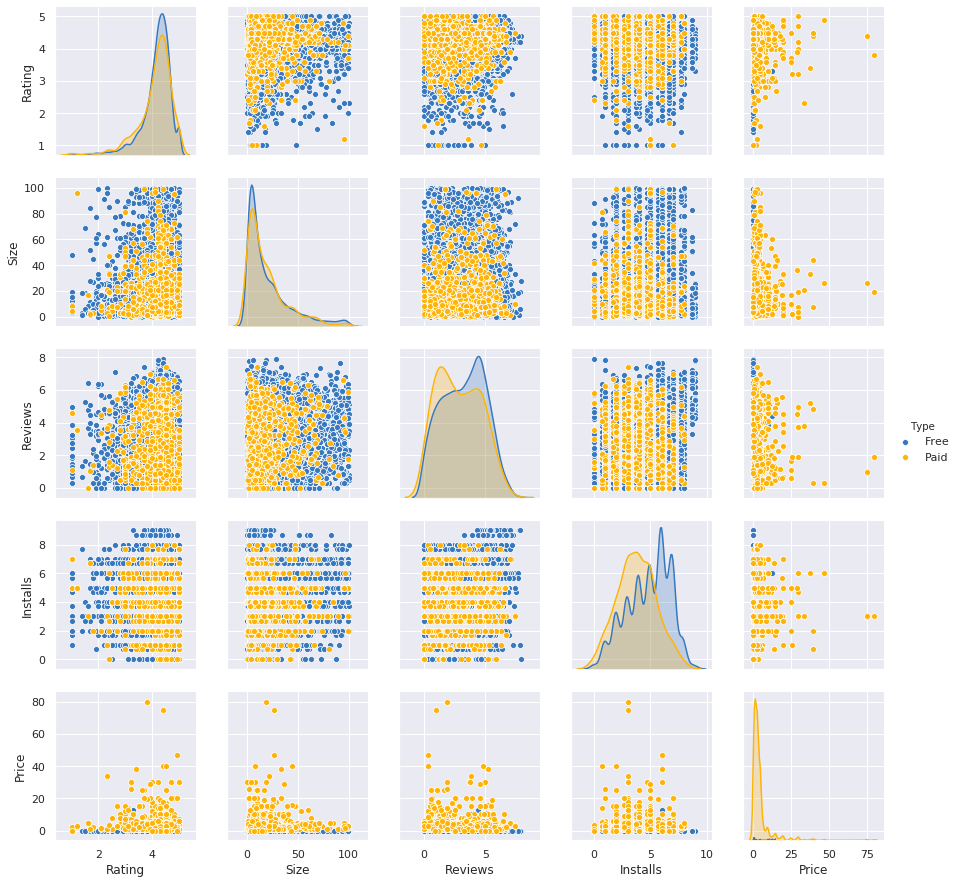

In [84]:
rating = df['Rating'].dropna()
size = df['Size'].dropna()
installs = np.log10(df['Installs'][df.Installs!=0].dropna()) #eliminate zeros f *or computing log
reviews = np.log10(df['Reviews'][df.Reviews!=0].dropna()) #eliminate zeros for computing log
app_type = df['Type'].dropna()
price = df['Price']

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
p = sns.pairplot(pd.DataFrame(list(zip(rating, size, reviews, installs, app_type, price)), 
                        columns=['Rating','Size', 'Reviews', 'Installs', 'Type', 'Price']), hue='Type', palette=sns.xkcd_palette(colors))

Exploring the number of apps per each category using a bar chart because it's just one number for each category with no continuity.

The graph shows that family apps are the most ones to exist on the app store.

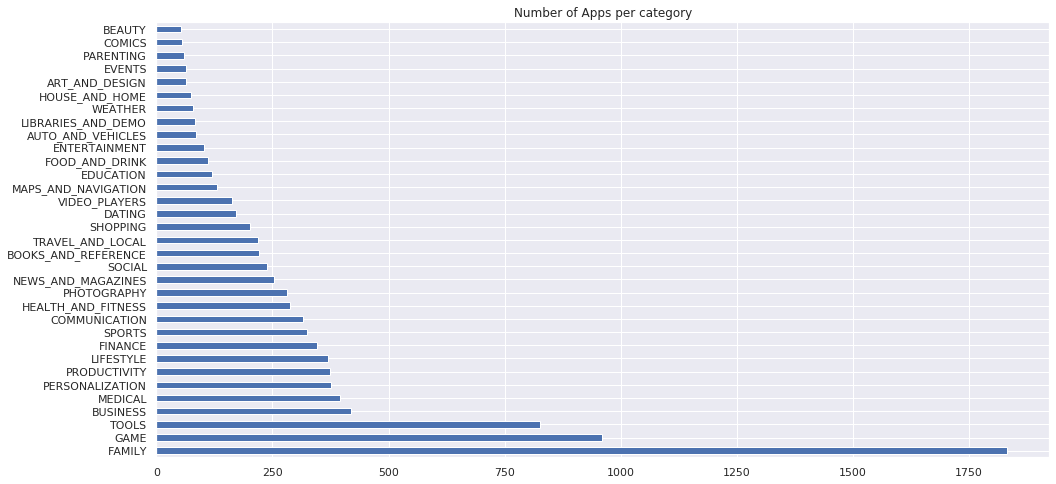

In [47]:
df['Category'].value_counts().plot(kind='barh',figsize= (16,8))
title=plt.title('Number of Apps per category')

Inspecting the number of installations per each category using bar charts only for the same reason mentioned above and we can see that despite Games are not the most apps to exist on the store, they're the most apps to be installed.

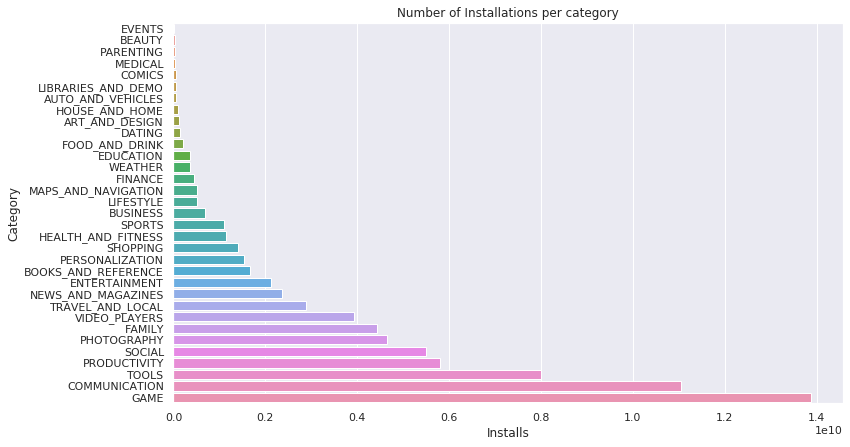

In [48]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Number of Installations per category')
result = df.groupby(["Category"])['Installs'].aggregate(np.sum).reset_index().sort_values('Installs')
bar=sns.barplot(y='Category',x='Installs', data=result, ci=None, order=result['Category'])
plt.show(bar)

The distribution of app ratings using histogram shows that the average app rating is 4.1

Average app rating =  4.173243045387998


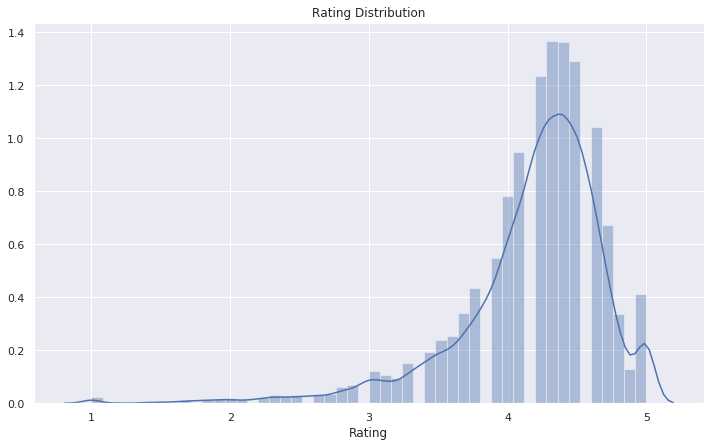

In [49]:
ig = plt.figure(figsize=(12,7))
title=plt.title('Rating Distribution')
hist=sns.distplot(df.Rating.dropna(),kde=True)
print('Average app rating = ', np.mean(df.Rating))
plt.show(hist)

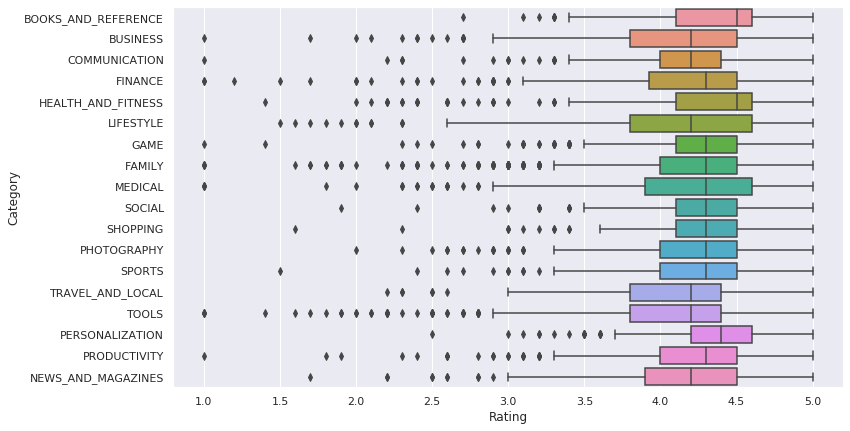

In [50]:
fig = plt.figure(figsize=(12,7))
cat_rate = df.groupby("Category").filter(lambda x: len(x) > 200)
bar = sns.boxplot(x="Rating", y="Category", data=cat_rate)
plt.show(bar)

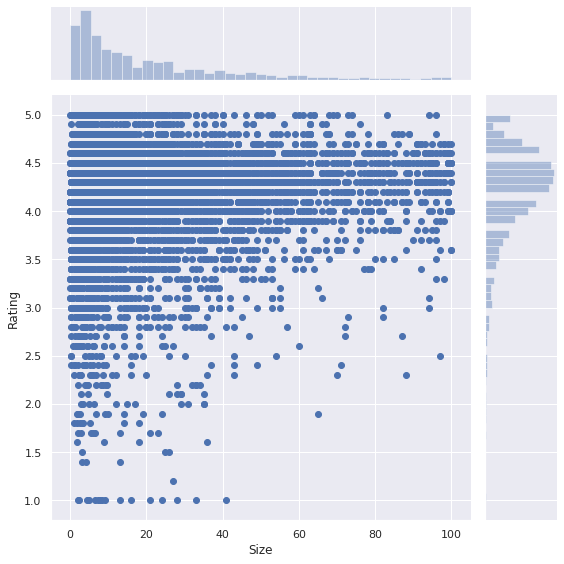

In [51]:
plot = sns.jointplot(df.Size, df.Rating,size=8)

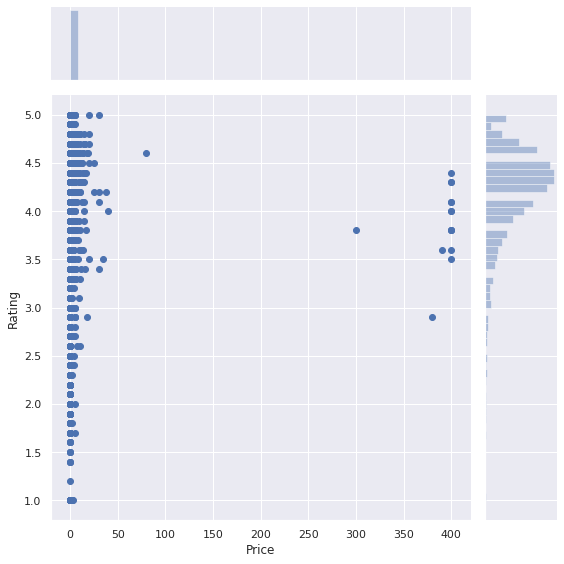

In [52]:
plot = sns.jointplot(df.Price, df.Rating,size=8)

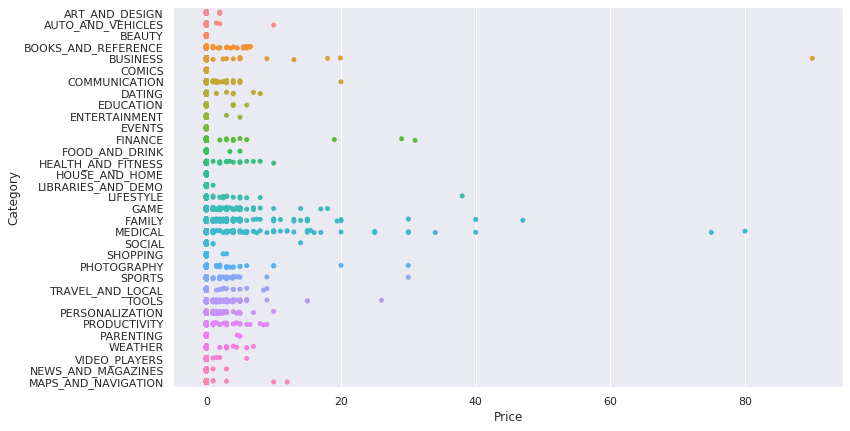

In [64]:

fig = plt.figure(figsize=(12,7))
result = df.groupby(["Category"])['Price'].aggregate(np.mean).reset_index().sort_values('Price')
# bar=sns.barplot(y='Category',x='Price', data=result, ci=None, order=result['Category'])
bar=sns.stripplot(y='Category',x='Price', data=df)
plt.show(bar)

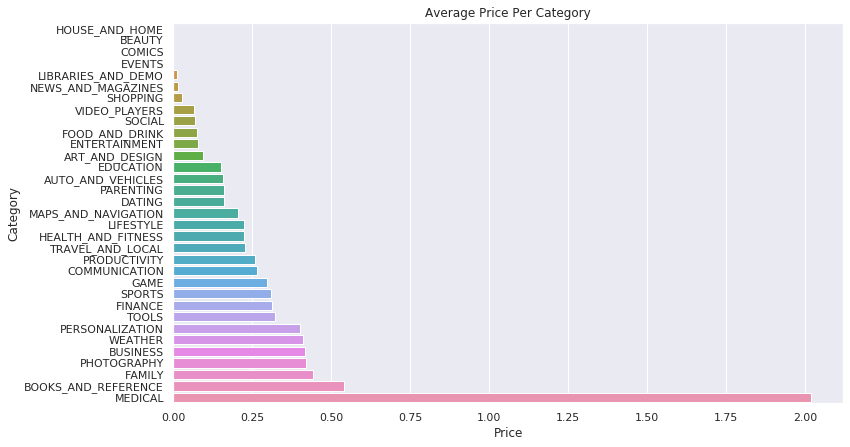

In [65]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Average Price Per Category')
result = df.groupby(["Category"])['Price'].aggregate(np.mean).reset_index().sort_values('Price')
bar=sns.barplot(y='Category',x='Price', data=result, ci=None, order=result['Category'])
plt.show(bar)

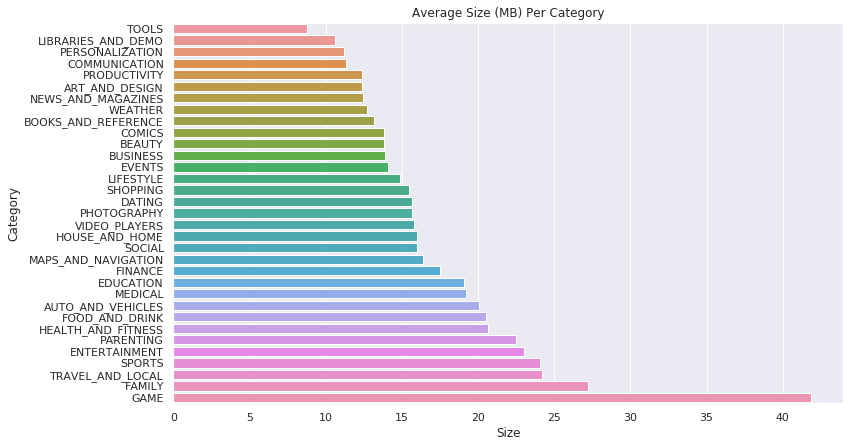

In [66]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Average Size (MB) Per Category')
result = df.groupby(["Category"])['Size'].aggregate(np.mean).reset_index().sort_values('Size')
bar=sns.barplot(y='Category',x='Size', data=result, ci=None, order=result['Category'])
plt.show(bar)

In [67]:
df[['Category', 'App','Price']][df.Price > 200]

,Category,App,Price


In [68]:
df = df[df.Price < 100]

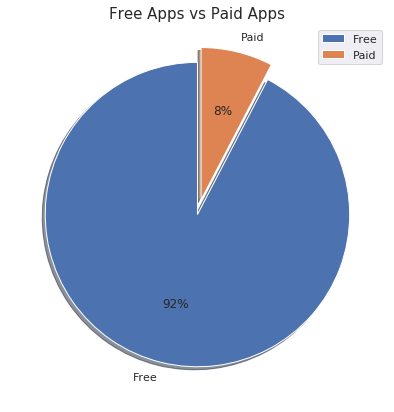

In [69]:
fig = plt.figure(figsize = (7,7))
labels = ['Free', 'Paid'] 
size = df['Type'].value_counts()
explode = [0, 0.1]

plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, autopct='%1.0f%%')
plt.title('Free Apps vs Paid Apps', fontsize = 15)
plt.legend()
plt.show()

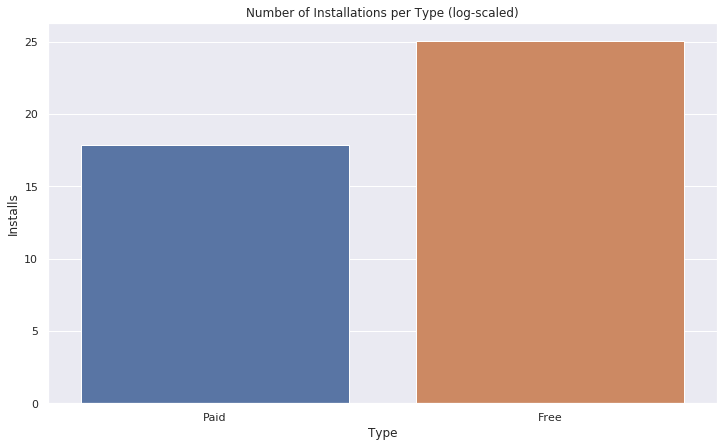

In [70]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Number of Installations per Type (log-scaled)')
result = df.groupby(["Type"])['Installs'].aggregate(np.sum).reset_index().sort_values('Installs')
bar=sns.barplot(x='Type',y=np.log(result.Installs), data=result, ci=None, order=result['Type'])
plt.show(bar)

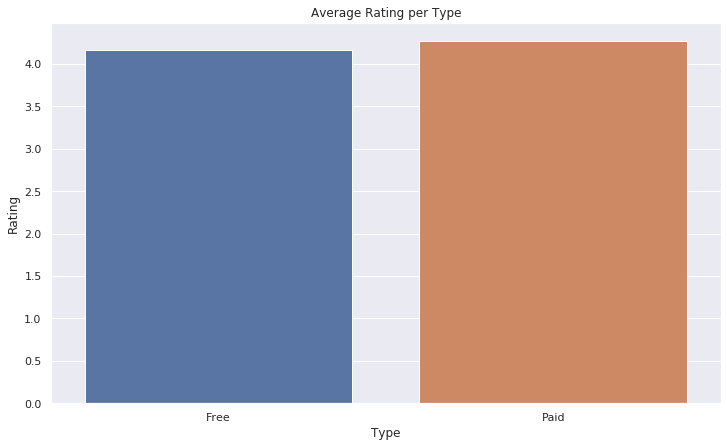

In [71]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Average Rating per Type')
result = df.groupby(["Type"])['Rating'].aggregate(np.mean).reset_index().sort_values('Rating')
bar=sns.barplot(x='Type',y=result.Rating, data=result, ci=None, order=result['Type'])
plt.show(bar)

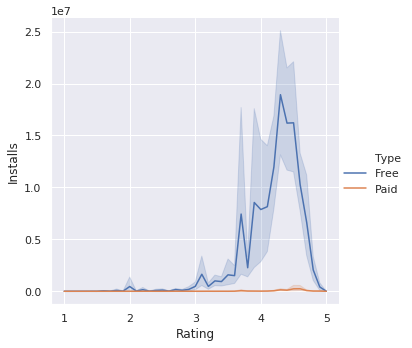

In [72]:
sns.relplot(x="Rating", y="Installs", hue = 'Type' , kind = 'line' , data=df)

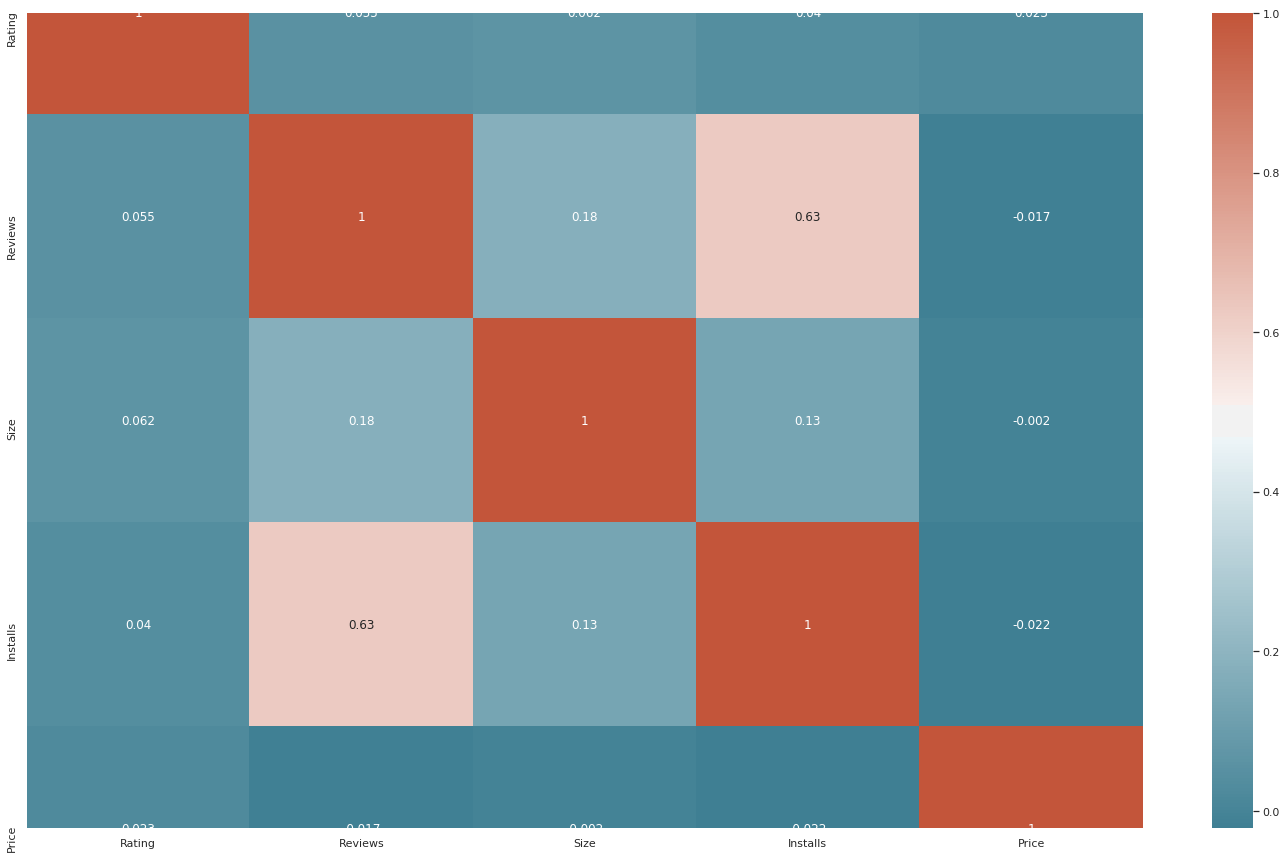

In [73]:
corr_mat = df.corr()
sns.heatmap(corr_mat, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [74]:
reviews_df = pd.read_csv('../android-app-market-analysis/data/googleplaystore_user_reviews.csv')
merged_df = pd.merge(df, reviews_df, on = "App", how = "inner")
merged_df = merged_df.dropna(subset=['Sentiment', 'Translated_Review'])

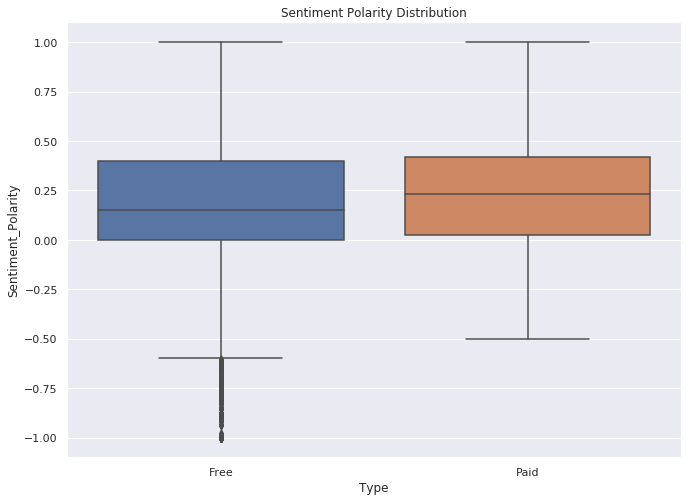

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
ax = sns.boxplot(x='Type', y='Sentiment_Polarity', data=merged_df)
title = ax.set_title('Sentiment Polarity Distribution')

In [82]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=500, colormap="Set2")
# generate word cloud

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop = stop + ['app', 'APP' ,'ap', 'App', 'apps', 'application', 'browser', 'website', 'websites', 'chrome', 'click', 'web', 'ip', 'address',
            'files', 'android', 'browse', 'service', 'use', 'one', 'download', 'email', 'Launcher']

merged_df['Translated_Review'] = merged_df['Translated_Review'].apply(lambda x: " ".join(x for x in str(x).split(' ') if x not in stop))
merged_df.Translated_Review = merged_df.Translated_Review.apply(lambda x: x if 'app' not in x.split(' ') else np.nan)
merged_df.dropna(subset=['Translated_Review'], inplace=True)

ModuleNotFoundError: No module named 'wordcloud'

In [77]:
free = merged_df.loc[merged_df.Type=='Free']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(free)))
plt.figure(figsize=(10, 15))
plt.title('Most Common Words in Free Apps Reviews')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

NameError: name 'wc' is not defined

In [78]:
paid = merged_df.loc[merged_df.Type=='Paid']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(paid)))
plt.figure(figsize=(10, 15))
plt.title('Most Common Words in Paid Apps Reviews')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

NameError: name 'wc' is not defined